Bayesian Bandits from Scratch
===

Code from a talk presented to the Boston Bayesian meetup, July 2016.

Copyright 2016 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

from thinkbayes2 import Suite
import thinkplot

import warnings
warnings.filterwarnings('ignore')

## The cookie problem

Create a Suite with two equally likely hypotheses.


In [2]:
cookie = Suite(['Bowl 1', 'Bowl 2'])
cookie.Print()

Bowl 1 0.5
Bowl 2 0.5


Update each hypothesis with the likelihood of the data (a vanilla cookie).

In [3]:
cookie['Bowl 1'] *= 0.75
cookie['Bowl 2'] *= 0.5
cookie.Normalize()

0.625

Print the posterior probabilities.

In [4]:
cookie.Print()

Bowl 1 0.6
Bowl 2 0.4


Suppose we put the first cookie back, stir, choose again from the same bowl, and get a chocolate cookie.

In [5]:
cookie['Bowl 1'] *= 0.25
cookie['Bowl 2'] *= 0.5
cookie.Normalize()
cookie.Print()

Bowl 1 0.428571428571
Bowl 2 0.571428571429


## The red dice problem

Create a Suite to represent six-sided dice with different numbers of red sides.

In [6]:
suite = Suite([0, 2, 4, 6])
suite.Print()

0 0.25
2 0.25
4 0.25
6 0.25


We can do the update by hand like this:

In [7]:
suite[0] *= 0
suite[2] *= 2/6
suite[4] *= 4/6
suite[6] *= 6/6

suite.Normalize()
suite.Print()

0 0.0
2 0.166666666667
4 0.333333333333
6 0.5


Now I'll do the same calculation using `Suite.Update`.

I'll define a new class called `RedDice` that extends `Suite`.

It provides a method called `Likelihood` that takes `data` and `hypo` and returns the probability of the data (the outcome of rolling the die) for a given hypothesis (number of red sides on the die).

In [8]:
class RedDice(Suite):
    # hypo is the number of red sides on the die
    # data is the outcome, either 'Red' or 'Blue'
    def Likelihood(self, data, hypo):
        p = hypo / 6
        if data == 'Red':
            return p
        else:
            return 1 - p

Now we can create a `RedDice` object and update it.

In [9]:
dice = RedDice([0, 2, 4, 6])
dice.Update('Red')
dice.Print()

0 0.0
2 0.166666666667
4 0.333333333333
6 0.5


If we get more data, we can perform more updates.

In [10]:
for roll in ['Red', 'Blue', 'Red']:
    dice.Update(roll)

Here are the results.

In [11]:
dice.Print()

0 0.0
2 0.2
4 0.8
6 0.0


## Bayesian bandits


Here's a definition for `Bandit`, which extends `Suite` and defines a likelihood function that computes the probability of the data (win or lose) for a given value of `x` (the probability of win).

Note that `hypo` is in the range 0 to 100.

In [12]:
class Bandit(Suite):
    
    def Likelihood(self, data, hypo):
        """ 
        hypo is the prob of win (0-100)
        data is a string, either 'W' or 'L'
        """
        x = hypo / 100
        if data == 'W':
            return x
        else:
            return 1-x

We'll start with a uniform distribution from 0 to 100.

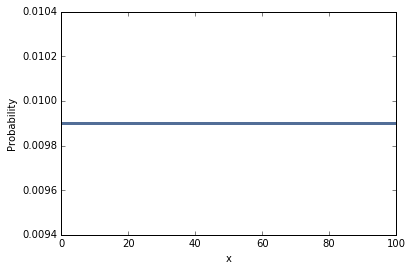

In [13]:
bandit = Bandit(range(101))
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

Now we can update with a single loss:

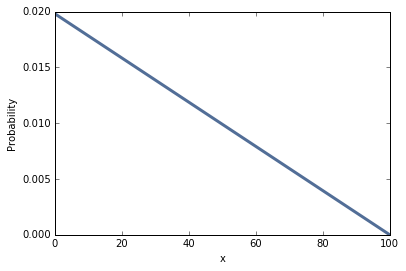

In [14]:
bandit.Update('L')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

Another loss:

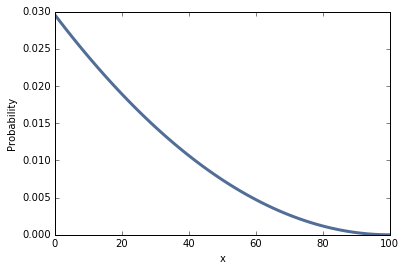

In [15]:
bandit.Update('L')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

And a win:

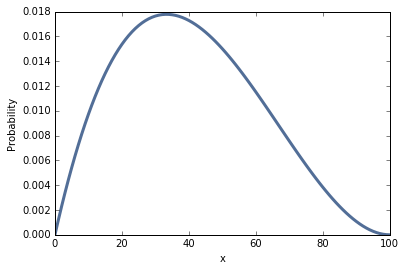

In [16]:
bandit.Update('W')
thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')

Starting over, here's what it looks like after 1 win and 9 losses.

10

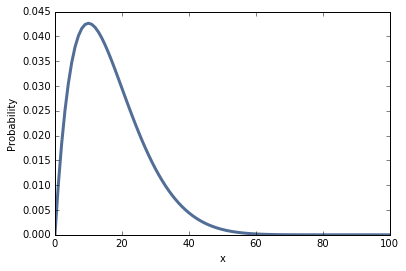

In [17]:
bandit = Bandit(range(101))

for outcome in 'LLWLLLLLLL':
    bandit.Update(outcome)

thinkplot.Pdf(bandit)
thinkplot.Config(xlabel='x', ylabel='Probability')
bandit.MaximumLikelihood()

The posterior mean is about 17%

In [18]:
bandit.Mean()

16.68194469884906

The most likely value is the observed proportion 1/10

In [19]:
bandit.MaximumLikelihood()

10

The posterior credible interval has a 90% chance of containing the true value (provided that the prior distribution truly represents our background knowledge).

In [20]:
bandit.CredibleInterval(90)

(3, 36)

## Bayesian A/B testing

Now suppose we have several bandits and we want to decide which one to play.

For this example, we have 4 machines with these probabilities:

In [21]:
actual_probs = [10, 20, 30, 40]

The following function simulates playing one machine once.

In [22]:
from random import random
from collections import Counter

counter = Counter()

def flip(p):
    return random() < p

def play(i):
    counter[i] += 1
    p = actual_probs[i] / 100
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [23]:
for i in range(20):
    result = play(3)
    print(result, end=' ')

W W W W W W L L L L W L W L L W W L L L 

Now I'll make 4 `Bandit` objects to represent our beliefs about the 4 machines.

In [24]:
prior = range(101)
beliefs = [Bandit(prior) for i in range(4)]

The core of the algorithm is this process for choosing which machine to play:

In [25]:
def choose(beliefs):
    ps = [b.Random() for b in beliefs]
    return np.argmax(ps)

Here's an example.

In [26]:
choose(beliefs)

2

This function updates our beliefs about one of the machines based on one outcome.

In [27]:
def update(beliefs, i, outcome):
    beliefs[i].Update(outcome)

Finally, this function chooses a machine, plays once, and updates `beliefs`:

In [28]:
def choose_play_update(beliefs, verbose=False):
    i = choose(beliefs)
    outcome = play(i)
    update(beliefs, i, outcome)
    if verbose:
        print(i, outcome, beliefs[i].Mean())

Here's an example

In [29]:
counter = Counter()
choose_play_update(beliefs, verbose=True)

0 L 33.0


This function displays the four posterior distributions

In [30]:
options = dict(yticklabels='invisible')

def plot(beliefs):
    thinkplot.preplot(rows=2, cols=2)
    for i, b in enumerate(beliefs):
        thinkplot.subplot(i+1)
        thinkplot.Pdf(b, label=i)
        thinkplot.config(**options)

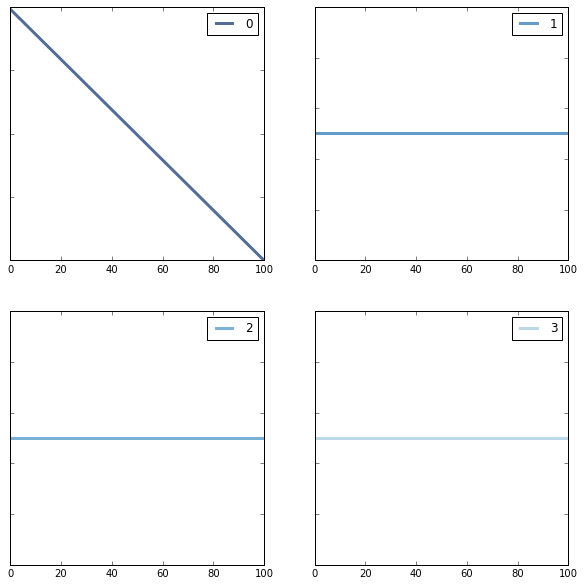

In [31]:
plot(beliefs)

Now we can play a few times and see how `beliefs` gets updated:

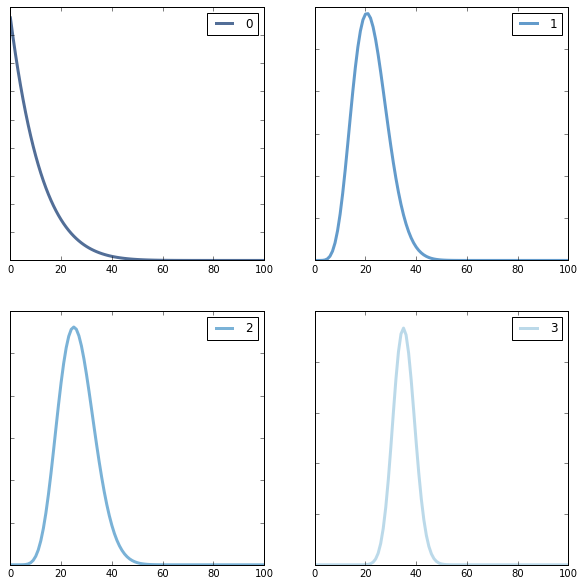

In [32]:
for i in range(200):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior mean and credible interval:

In [33]:
for i, b in enumerate(beliefs):
    print(b.Mean(), b.CredibleInterval(90))

9.55671624054 (0, 28)
22.2222222206 (12, 34)
26.3157894737 (15, 39)
35.2 (28, 42)


The credible intervals usually contain the true value, but the estimates are still rough, especially for the lower-probability machines.

But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

In [34]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 8
1 34
2 36
3 123
